# Making noise maps for SPT, SO, CMB-S4, with null/consistency tests

In [1]:
import sys
import os
sys.path.append('../../ThumbStack')
sys.path.append('../../LensQuEst')
import importlib

import flat_map
importlib.reload(flat_map)
from flat_map import *

import matplotlib.pyplot as plt
import cmasher as cm
%matplotlib inline

import numpy as np
import fitsio
import pixell
importlib.reload(pixell)
from functools import partial

In [8]:
plt.style.use('default.mplstyle')

def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [3]:
# some constants
rad2arcmin = 180. * 60. / np.pi
arcmin2rad = 1/rad2arcmin
peaktau = 2.45e-4
tau_fwhm = 5.
tau_sigma = 5 / np.sqrt(8*np.log(2))
gauss_norm = 2 * np.pi * tau_sigma**2

In [4]:
def make_basemap():
    # map dimensions in degrees
    sizeX = 10.
    sizeY = 10.
    
    # number of pixels for the flat map, let's do 0.5' pixels
    nX = int(sizeX*60.*2.)
    nY = int(sizeY*60.*2.)
    
    # basic map object
    baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

    # order: [[ra_min, dec_max], [ra_max, dec_min]]
    box = np.array([[10., 210.], [20., 200.]]) * utils.degree
    resArcmin = 0.5  # map pixel size [arcmin]
    shape,wcs = enmap.geometry(pos=box, res=resArcmin * utils.arcmin, proj='cea')
    
    # create a mask that keeps the whole area
    boxMask = enmap.ones(shape, wcs=wcs)
    # pixsizemap = boxMask.pixsizemap()
    return baseMap, boxMask, wcs

In [5]:
fwhm = 5.
sigma = fwhm / np.sqrt(8.*np.log(2))
denorm = 2. * np.pi * sigma**2
pixarea = 0.25 # approx
peaktau = 2.45e-4

# Check norm for AdvACT noise map

In [6]:
sys.path.append('../scripts/')
from make_noise_maps import make_cmb, gen_lensed_map, gen_map_from_data_powspec

Text(0, 0.5, '$C_{\\ell}$')

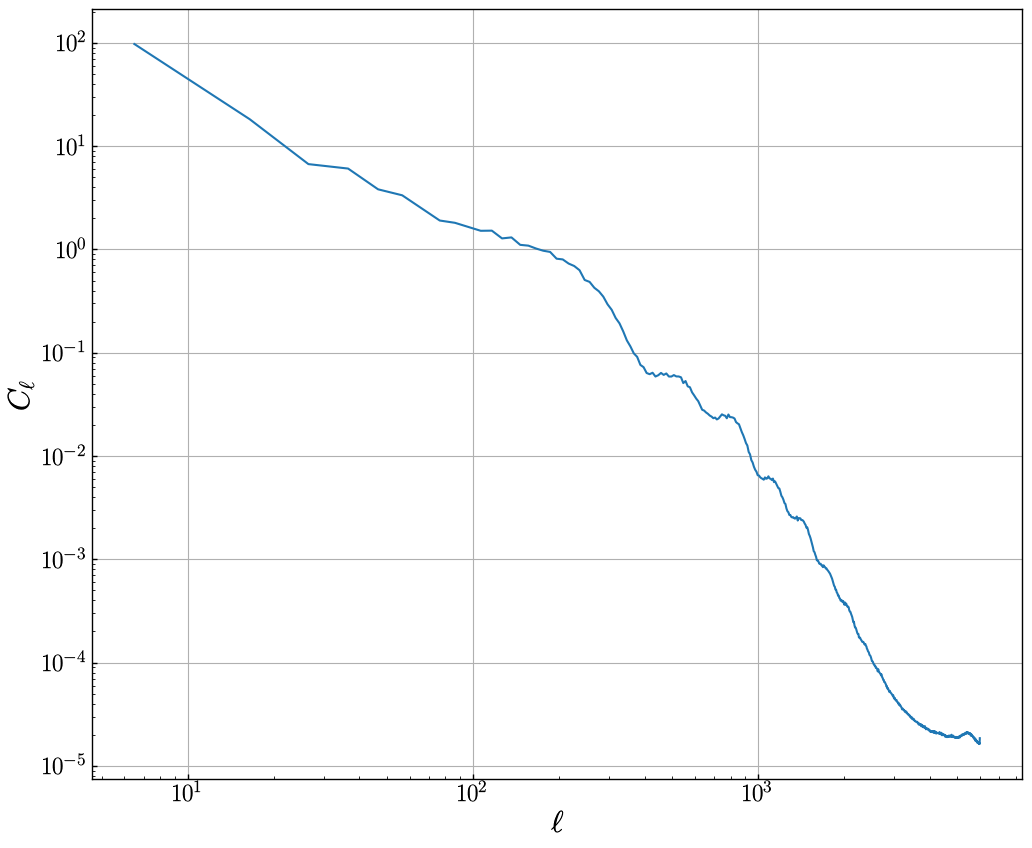

In [9]:
datadir = '/home/theo/Documents/research/CMB/patchy_tau_sims/data/AdvACT_NILC_cls_fullRes_TT/'
ell = np.load(datadir+'ells.npy')
cl = np.load(datadir+'cl_tt.npy')
cmb = make_cmb()
plt.plot(ell, cl)
plt.loglog()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

In [151]:
# kappa_fits = '/home/theo/Documents/research/CMB/patchy_tau_sims/output/fg_maps/kappamap_0.53arcminGauss_correlatedwithTaumap_cmass_10x10_image.fits'
# lensmap = gen_lensed_map(kappa_fits, 'lencmb0')

Generating map


KeyboardInterrupt: 

In [ ]:
actmap = gen_map_from_data_powspec(ell, cl, cmb, lensmap, name='actnilc')
act_ell, act_cl, act_scl = actmap.powerSpectrum(lRange=ell, nBins=600, plot=True)

Text(0, 0.5, '$C_{\\ell} [\\mu$K$^2$')

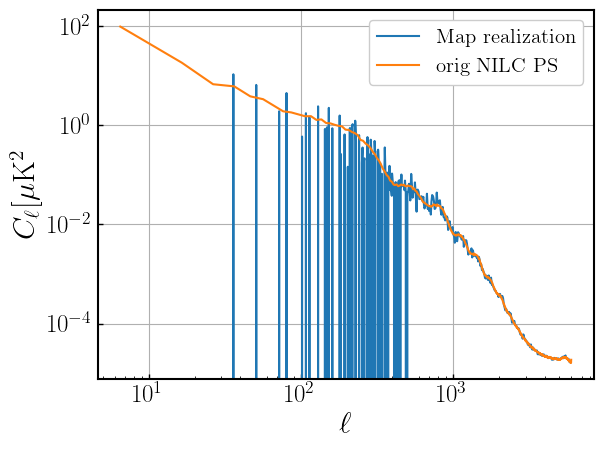

In [248]:
plt.plot(act_ell, act_cl, label='Map realization')
# plt.plot(lens_ell[lpf], lens_cl[lpf]*2, label=r'lensed theory CMB $\times$ 2', ls=':')
plt.plot(ell, cl, label=r'orig NILC PS')
plt.loglog()
plt.legend(framealpha=1., fontsize=15)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell} [\mu$K$^2$')

In [ ]:
# from gen_map_from_curve
"""
def gen_map_from_curve(ell, f, cmb, flat_map, name, seed=42):
    print('Generating map')
    # reinterpolate: gain factor 10 in speed
    # first interpolate lensed CMB
    forCtotal = lambda l: cmb.flensedTT(l)
    F = np.array(list(map(forCtotal, ell)))
    # then add on interpolated noise curve
    F += f
    # add the beam
    F = F * cmb.fbeam(ell)**2
    cmb.fCtotal = interp1d(ell, F, kind='linear', bounds_error=False, fill_value=0.)
"""
#LOLOL added lensed cmb to NILC spectrum RIIIP

(100.0, 100000.0)

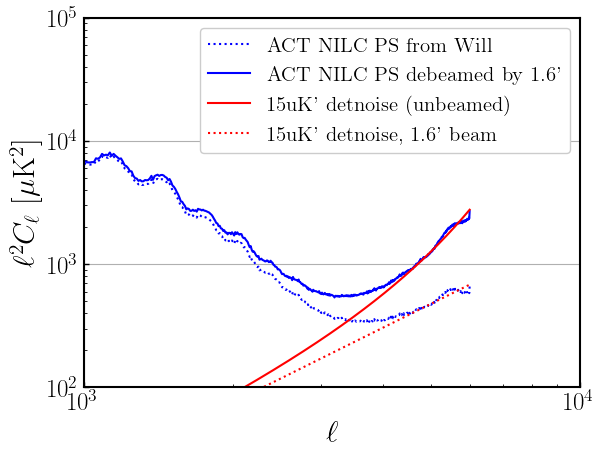

In [251]:
cmb = make_cmb(lMax=20000, beam=1.6, noise=15.)
cmb.fCtotal = interp1d(ell, cl, kind='linear', bounds_error=False, fill_value=0.)
# plt.plot(act_ell, act_ell**2*act_cl, label='Map realization')
plt.plot(ell, ell**2*cl, label=r'ACT NILC PS from Will', c='b', ls=':')
plt.plot(ell, ell**2*(cl / cmb.fbeam(ell)**2), label=r"ACT NILC PS debeamed by 1.6'", c='b')
# plt.plot(ell, ell**2*cl * cmb.fbeam(ell)**2, label=r'orig NILC PS extra beamed')
# plt.plot(ell, ell**2*cmb.fCtotal(ell), label=r'new AdvACT NILC PS', ls=':')
plt.plot(ell, ell**2*cmb.fdetectorNoise(ell), label="15uK' detnoise (unbeamed)", c='r')
plt.plot(ell, ell**2*(cmb.fdetectorNoise(ell) * cmb.fbeam(ell)**2), label="15uK' detnoise, 1.6' beam", c='r', ls=':')
plt.loglog()
plt.legend(framealpha=1., fontsize=15)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^2 C_{\ell}$ [$\mu$K$^2$]')
plt.xlim(1e3, 1e4)
plt.ylim(1e2, 1e5)

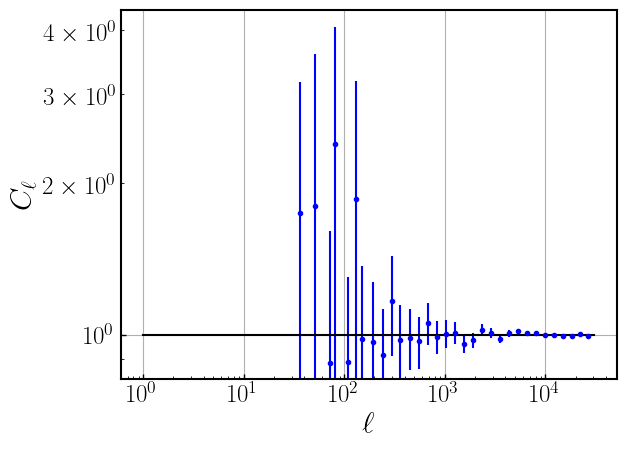

l=0 mode is: 0j


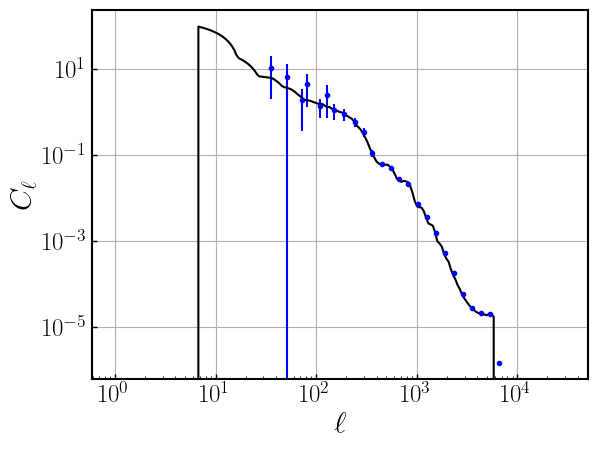

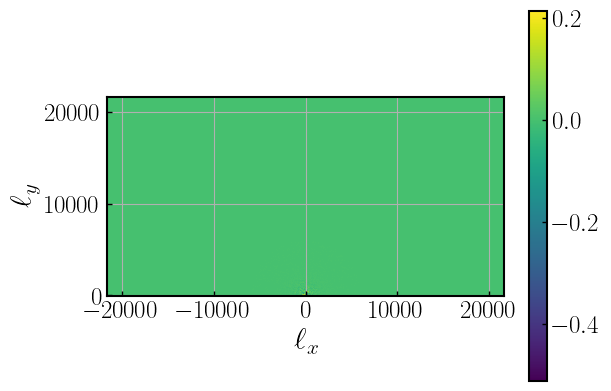

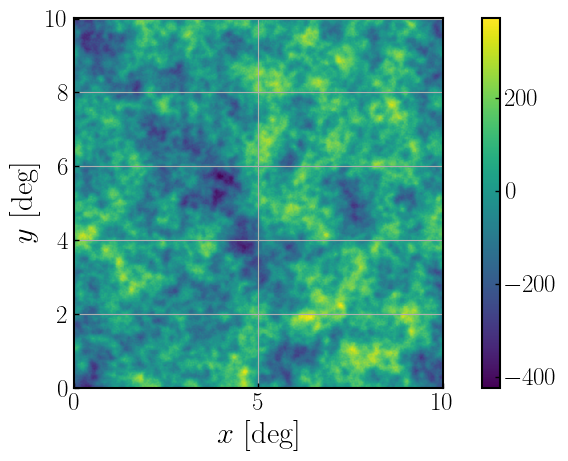

In [139]:
# make map data
noise_map = lensmap.copy()
noise_map.dataFourier = noise_map.genGRF(cmb.fCtotal, seed=42, test=True)
noise_map.data = noise_map.inverseFourier()
name = 'advACT_nilc_v2_orig'
noise_map.name = name

In [310]:
from make_noise_maps import save_map

In [141]:
path = '/home/theo/Documents/research/CMB/patchy_tau_sims/output/cmb_maps/10x10_noise_maps/'
save_map(noise_map, cmb, path, name)

plot and save CMB map png
saving plot to /home/theo/Documents/research/CMB/patchy_tau_sims/output/cmb_maps/10x10_noise_maps/advACT_nilc_v2_orig/advACT_nilc_v2_orig_map.png
plot and save the power spectrum
Saving plot to: /home/theo/Documents/research/CMB/patchy_tau_sims/output/cmb_maps/10x10_noise_maps/advACT_nilc_v2_orig/advACT_nilc_v2_orig_powspec.png
Saving flatmap: /home/theo/Documents/research/CMB/patchy_tau_sims/output/cmb_maps/10x10_noise_maps/advACT_nilc_v2_orig/advACT_nilc_v2_orig_flatmap.fits
writing to /home/theo/Documents/research/CMB/patchy_tau_sims/output/cmb_maps/10x10_noise_maps/advACT_nilc_v2_orig/advACT_nilc_v2_orig_flatmap.fits


<Figure size 640x480 with 0 Axes>

## SPT

In [252]:
datadir = '/home/theo/Documents/research/CMB/patchy_tau_sims/data/noisecurve_subset/'
dat = np.load(datadir + 'spt_proposal_2023_ilc_cmb_90-150-220_TT-EE_fsky1500_5years.npy', allow_pickle=True)

In [253]:
data = dat.tolist()

In [254]:
data['el']

array([    0,     1,     2, ..., 11998, 11999, 12000])

In [255]:
ell = data['el']
cl = data['cl_residual']['TT']

[]

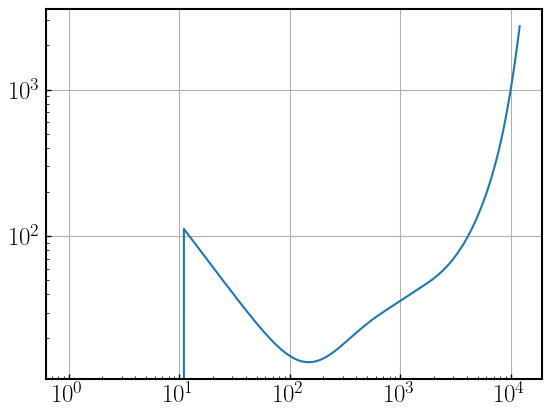

In [222]:
plt.plot(ell, ell**2*cl)
plt.loglog()

In [223]:
# plot noise, beamed noise, beamed spectrum, debeamed spectrum

(1.0, 10000.0)

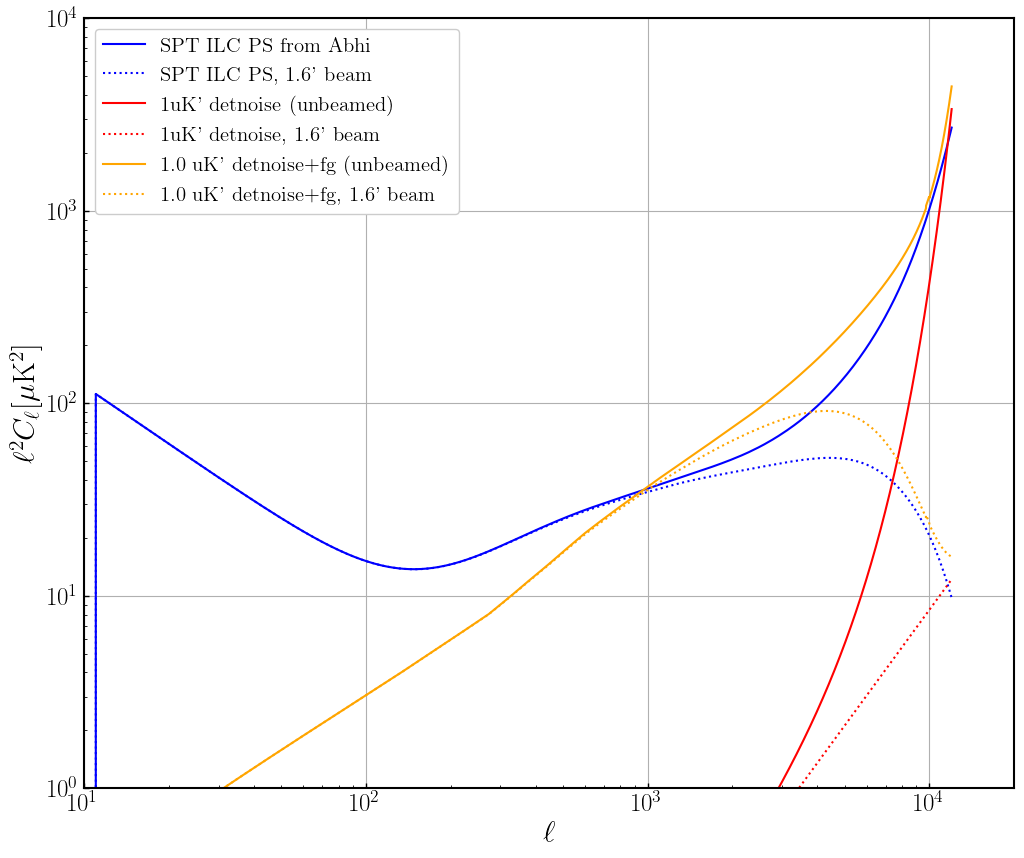

In [260]:
# https://arxiv.org/pdf/2101.01684.pdf
# SPT-3G beam (see §IV E), with FWHMs of
# 1.7', 1.4', 1.2' at 95, 150, 220 GHz, respectively

beam = 1.6
noise = 1.
cmb = make_cmb(lMax=20000, beam=beam, noise=noise)
fig, ax = plt.subplots(1,1, figsize=(12,10))
# cmb.fCtotal = interp1d(ell, cl, kind='linear', bounds_error=False, fill_value=0.)

# plt.plot(act_ell, act_ell**2*act_cl, label='Map realization')
plt.plot(ell, ell**2*cl, label=r'SPT ILC PS from Abhi', c='b')
plt.plot(ell, ell**2*(cl * cmb.fbeam(ell)**2), label=r"SPT ILC PS, 1.6' beam", c='b', ls=':')
# plt.plot(ell, ell**2*(cl / cmb.fbeam(ell)**2), label=r"SPT ILC PS, debeamed by 1.6' beam")
plt.plot(ell, ell**2*cmb.fdetectorNoise(ell), label="1uK' detnoise (unbeamed)", c='r')
plt.plot(ell, ell**2*(cmb.fdetectorNoise(ell) * cmb.fbeam(ell)**2), label="1uK' detnoise, 1.6' beam", c='r', ls=':')

plt.plot(ell, ell**2*(cmb.ftotal(ell) - cmb.flensedTT(ell)), label=r"%.1f uK' detnoise+fg (unbeamed)"%(noise), c='orange')
plt.plot(ell, ell**2*((cmb.ftotal(ell) - cmb.flensedTT(ell)) * cmb.fbeam(ell)**2),
         label=r"%.1f uK' detnoise+fg, 1.6' beam"%(noise), c='orange', ls=':')

# plt.plot(act_ell, act_ell**2*act_cl, label='Map realization')
# plt.plot(ell, ell**2*cl, label=r'SPT ILC PS')
# plt.plot(ell, ell**2*cl / cmb.fbeam(ell)**2, label=r'SPT ILC PS debeamed')
# # plt.plot(ell, ell**2*cl * cmb.fbeam(ell)**2, label=r'SPT ILC PS extra beamed')
# # plt.plot(ell, ell**2*cmb.fCtotal(ell), label=r'new AdvACT NILC PS', ls=':')
# plt.plot(ell, ell**2*cmb.fdetectorNoise(ell) * cmb.fbeam(ell)**2, label='detnoise beamed')
plt.loglog()
plt.legend(framealpha=1., fontsize=15)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^2C_{\ell} [\mu$K$^2$]')
plt.xlim(1e1, 2e4)
plt.ylim(1e0, 1e4)

# Simons Observatory

In [243]:
datadir = '/home/theo/Documents/research/CMB/patchy_tau_sims/data/noisecurve_subset/'
dat = np.genfromtxt(datadir + 'SOV3_T_default1-4-2_noisecurves_deproj0_SENS1_mask_16000_ell_TT_yy.txt')
print(dat)

[[4.00000000e+01 1.01940909e-04 3.46827986e-17]
 [4.10000000e+01 1.01877076e-04 3.63653674e-17]
 [4.20000000e+01 1.01813284e-04 3.81295627e-17]
 ...
 [7.97700000e+03 5.08562568e-05 5.56002410e-18]
 [7.97800000e+03 5.08686629e-05 5.56300906e-18]
 [7.97900000e+03 5.08810719e-05 5.56599562e-18]]


(10.0, 10000.0)

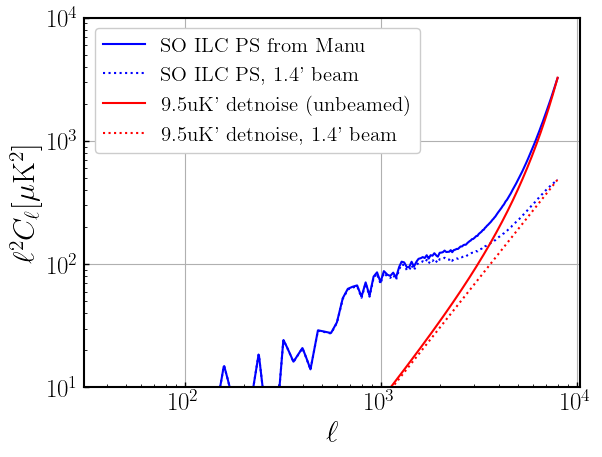

In [244]:
ell = dat[:,0]
cl = dat[:,1]
beam = 1.4
noise = 9.5
cmb = make_cmb(lMax=20000, beam=beam, noise=noise)
cmb.fCtotal = interp1d(ell, cl, kind='linear', bounds_error=False, fill_value=0.)

# plt.plot(act_ell, act_ell**2*act_cl, label='Map realization')
plt.plot(ell, ell**2*cl, label=r'SO ILC PS from Manu', c='b')
plt.plot(ell, ell**2*(cl * cmb.fbeam(ell)**2), label=r"SO ILC PS, 1.4' beam", c='b', ls=':')
plt.plot(ell, ell**2*(cmb.fdetectorNoise(ell)), label=r"%.1fuK' detnoise (unbeamed)"%(noise), c='r')
plt.plot(ell, ell**2*(cmb.fdetectorNoise(ell) * cmb.fbeam(ell)**2), label=r"%.1fuK' detnoise, %.1f' beam"%(noise, beam), c='r', ls=':')
# plt.plot(ell, ell**2*cl * cmb.fbeam(ell)**2, label=r'SPT ILC PS extra beamed')
# plt.plot(ell, ell**2*cmb.fCtotal(ell), label=r'new AdvACT NILC PS', ls=':')
# plt.plot(ell, ell**2*cmb.fdetectorNoise(ell), label='detnoise debeamed')
# plt.plot(ell, ell**2*cmb.fdetectorNoise(ell) * cmb.fbeam(ell)**2, label='detnoise beamed')
plt.loglog()
plt.legend(framealpha=1., fontsize=15)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^2C_{\ell} [\mu$K$^2$]')
plt.ylim(1e1, 1e4)

# CMB-S4

(100, 20000)

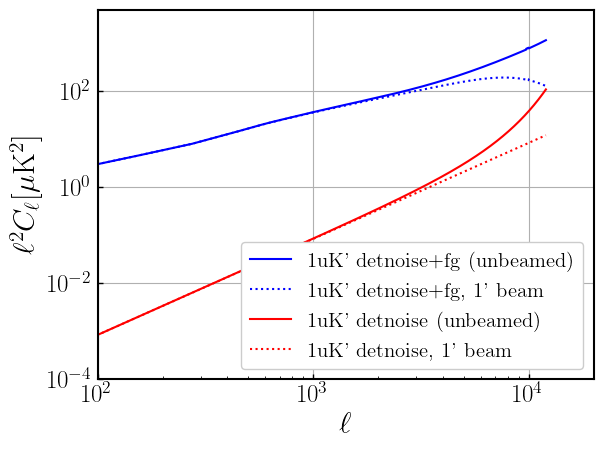

In [264]:
cmb = make_cmb(lMax=20000, beam=1., noise=1.)
# cmb.fCtotal = interp1d(ell, cl, kind='linear', bounds_error=False, fill_value=0.)

# plt.plot(act_ell, act_ell**2*act_cl, label='Map realization')
plt.plot(ell, ell**2*(cmb.ftotal(ell) - cmb.flensedTT(ell)), label=r"1uK' detnoise+fg (unbeamed)", c='b')
plt.plot(ell, ell**2*((cmb.ftotal(ell) - cmb.flensedTT(ell)) * cmb.fbeam(ell)**2), label=r"1uK' detnoise+fg, 1' beam", c='b', ls=':')
# plt.plot(ell, ell**2*(cmb.ftotalTT(ell) - cmb.flensedTT(ell)) * cmb.fbeam(ell)**2, label=r'Forecase S4 extra beamed')
# plt.plot(ell, ell**2*cmb.fCtotal(ell), label=r'new AdvACT NILC PS')
plt.plot(ell, ell**2*cmb.fdetectorNoise(ell), label="1uK' detnoise (unbeamed)", c='r')
plt.plot(ell, ell**2*(cmb.fdetectorNoise(ell) * cmb.fbeam(ell)**2), label="1uK' detnoise, 1' beam", c='r', ls=':')
# plt.plot(ell, ell**2*cmb.fdetectorNoise(ell) * cmb.fbeam(ell)**2, label='detnoise')
plt.loglog()
plt.legend(framealpha=1., fontsize=15)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^2C_{\ell} [\mu$K$^2$]')
plt.ylim(1e-4, 5e3)
plt.xlim(100, 20000)

# Combined

In [10]:
datadir = '/home/theo/Documents/research/CMB/patchy_tau_sims/data/AdvACT_NILC_cls_fullRes_TT/'
act_ell = np.load(datadir+'ells.npy')
act_cl = np.load(datadir+'cl_tt.npy')

datadir = '/home/theo/Documents/research/CMB/patchy_tau_sims/data/noisecurve_subset/'
data = np.load(datadir + 'spt_proposal_2023_ilc_cmb_90-150-220_TT-EE_fsky1500_5years.npy', allow_pickle=True).tolist()
spt_ell = data['el']
spt_cl = data['cl_residual']['TT']

so_dat = np.genfromtxt(datadir + 'SOV3_T_default1-4-2_noisecurves_deproj0_SENS1_mask_16000_ell_TT_yy.txt')
so_ell = so_dat[:,0]
so_cl = so_dat[:,1]

so_goal_dat = np.genfromtxt(datadir + 'SOV3_T_default1-4-2_noisecurves_deproj0_SENS2_mask_16000_ell_TT_yy.txt')
so_goal_ell = so_goal_dat[:,0]
so_goal_cl = so_goal_dat[:,1]
so_goal_cl_interp = interp1d(so_goal_ell, so_goal_cl, kind='linear', bounds_error=False, fill_value=0.)
so_goal_ell_interp = np.logspace(np.log10(40), np.log10(6000), 50)

/home/theo/Documents/research/CMB/patchy_tau_sims/notebooks/../../ThumbStack/cmb.py:31: RuntimeWarning: divide by zero encountered in divide
  self.fdl_to_cl = lambda l: 1./( l*(l+1.)/(2.*np.pi) )
/home/theo/Documents/research/CMB/patchy_tau_sims/notebooks/../../ThumbStack/cmb.py:79: RuntimeWarning: invalid value encountered in multiply
  self.flensedTT = lambda l: ((l>=lmin_lensedCMB) & (l<=lmax_lensedCMB)) * self.flensedTT_template(l) * self.fdl_to_cl(l)
/home/theo/Documents/research/CMB/patchy_tau_sims/notebooks/../../ThumbStack/cmb.py:301: RuntimeWarning: invalid value encountered in multiply
  return a_CIBP * (l/3000.)**2 * self.mu(nu1, betaP, Td)*self.mu(nu2, betaP, Td)/self.mu(150.e9, betaP, Td)**2 * self.fdl_to_cl(l)
/home/theo/Documents/research/CMB/patchy_tau_sims/notebooks/../../ThumbStack/cmb.py:312: RuntimeWarning: invalid value encountered in multiply
  return a_CIBC * (l/3000.)**(2-n) * self.mu(nu1, betaC, Td)*self.mu(nu2, betaC, Td)/self.mu(150.e9, betaC, Td)**2 * self.

(30, 10000.0)

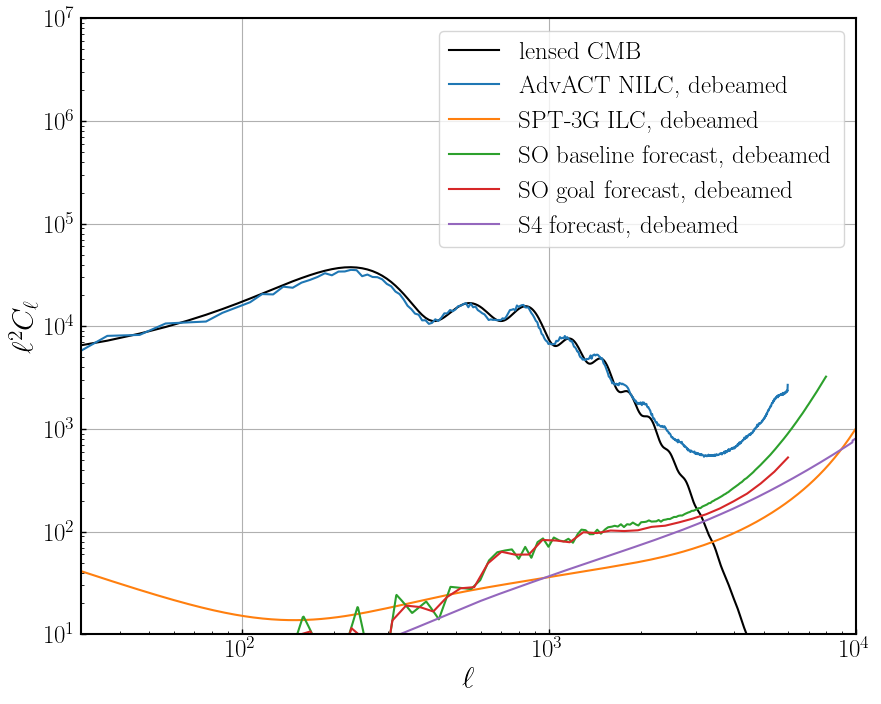

In [9]:
beam = 1.6
noise = 5.
cmb = make_cmb(lMax=20000, beam=beam, noise=noise)
fig, ax = plt.subplots(1,1, figsize=(10,8))
plt.plot(act_ell, act_ell**2*cmb.flensedTT(act_ell), label=r'lensed CMB', c='k')
plt.plot(act_ell, act_ell**2*act_cl / cmb.fbeam(act_ell)**2, label=r'AdvACT NILC, debeamed')
plt.plot(spt_ell, spt_ell**2*spt_cl, label=r'SPT-3G ILC, debeamed')
plt.plot(so_ell, so_ell**2*so_cl, label=r'SO baseline forecast, debeamed')
plt.plot(so_goal_ell_interp, so_goal_ell_interp**2*so_goal_cl_interp(so_goal_ell_interp), label=r'SO goal forecast, debeamed')

cmb = make_cmb(lMax=20000, beam=1., noise=1.)
plt.plot(spt_ell, spt_ell**2*(cmb.ftotal(spt_ell) - cmb.flensedTT(spt_ell)), label=r'S4 forecast, debeamed')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^2C_{\ell}$')
plt.loglog()
plt.legend()
plt.ylim(1e1, 1e7)
plt.xlim(30, 1e4)

/home/theo/Documents/research/CMB/patchy_tau_sims/notebooks/../../ThumbStack/cmb.py:31: RuntimeWarning: divide by zero encountered in divide
  self.fdl_to_cl = lambda l: 1./( l*(l+1.)/(2.*np.pi) )
/home/theo/Documents/research/CMB/patchy_tau_sims/notebooks/../../ThumbStack/cmb.py:79: RuntimeWarning: invalid value encountered in multiply
  self.flensedTT = lambda l: ((l>=lmin_lensedCMB) & (l<=lmax_lensedCMB)) * self.flensedTT_template(l) * self.fdl_to_cl(l)
/home/theo/Documents/research/CMB/patchy_tau_sims/notebooks/../../ThumbStack/cmb.py:301: RuntimeWarning: invalid value encountered in multiply
  return a_CIBP * (l/3000.)**2 * self.mu(nu1, betaP, Td)*self.mu(nu2, betaP, Td)/self.mu(150.e9, betaP, Td)**2 * self.fdl_to_cl(l)
/home/theo/Documents/research/CMB/patchy_tau_sims/notebooks/../../ThumbStack/cmb.py:312: RuntimeWarning: invalid value encountered in multiply
  return a_CIBC * (l/3000.)**(2-n) * self.mu(nu1, betaC, Td)*self.mu(nu2, betaC, Td)/self.mu(150.e9, betaC, Td)**2 * self.

(30, 10000.0)

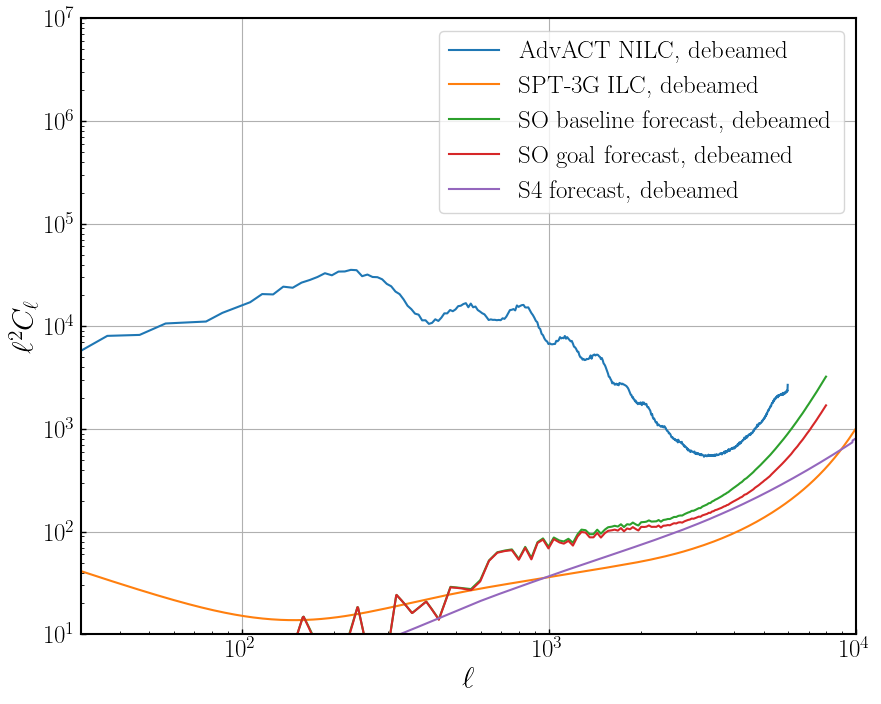

In [10]:
beam = 1.6
noise = 15.
cmb = make_cmb(lMax=20000, beam=beam, noise=noise)
fig, ax = plt.subplots(1,1, figsize=(10,8))
# plt.plot(act_ell, act_ell**2*cmb.flensedTT(act_ell), label=r'lensed CMB', c='k')
plt.plot(act_ell, act_ell**2*act_cl / cmb.fbeam(act_ell)**2, label=r'AdvACT NILC, debeamed')
plt.plot(spt_ell, spt_ell**2*spt_cl, label=r'SPT-3G ILC, debeamed')
plt.plot(so_ell, so_ell**2*so_cl, label=r'SO baseline forecast, debeamed')
plt.plot(so_goal_ell, so_goal_ell**2*so_goal_cl, label=r'SO goal forecast, debeamed')

cmb = make_cmb(lMax=20000, beam=1., noise=1.)
plt.plot(spt_ell, spt_ell**2*(cmb.ftotal(spt_ell) - cmb.flensedTT(spt_ell)), label=r'S4 forecast, debeamed')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^2C_{\ell}$')
plt.loglog()
plt.legend()
plt.ylim(1e1, 1e7)
plt.xlim(30, 1e4)

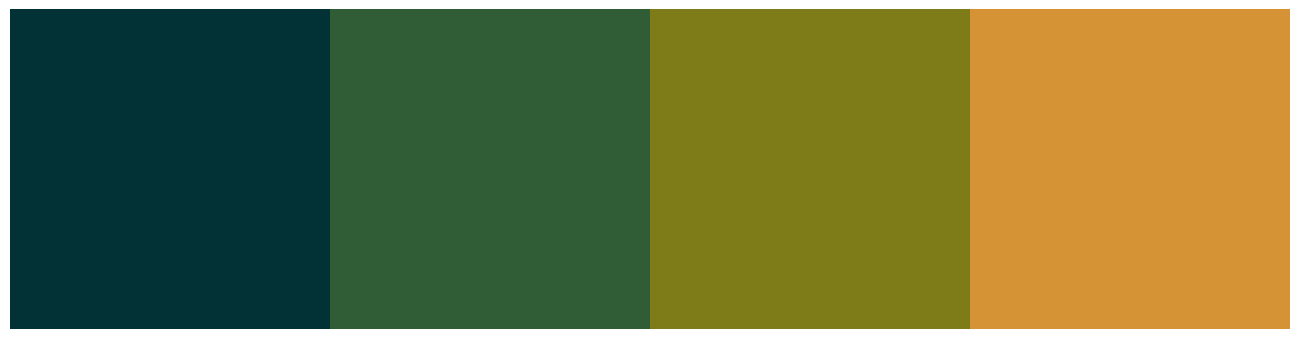

['#ea8463', '#89ad79', '#43868f', '#705171']


In [11]:
range = (0.2, 0.7)
N = 4
cmap = cm.get_sub_cmap('cmr.savanna', range[0], range[1], N=N)
cm.view_cmap(cmap)
cols = cm.take_cmap_colors(cmap, N, return_fmt='hex')
# cols = cm.take_cmap_colors('cmr.voltage', 4, cmap_range=(0.2, 0.7), return_fmt='hex')
cols = ['#a60032', '#b45b63', '#b79498', '#aacad1'] #red to light blue
cols = ['#cb4d4b', '#c07973', '#ab9e9d', '#81c1c9'] # red-orange to light blue
cols = ['#705171', '#43868f', '#89ad79', '#ffc683']
cols = ['#705171', '#43868f', '#89ad79', '#e6714b']
cols = ['#705171', '#43868f', '#89ad79', '#ea8463']
cols = cols[::-1]
print(cols)

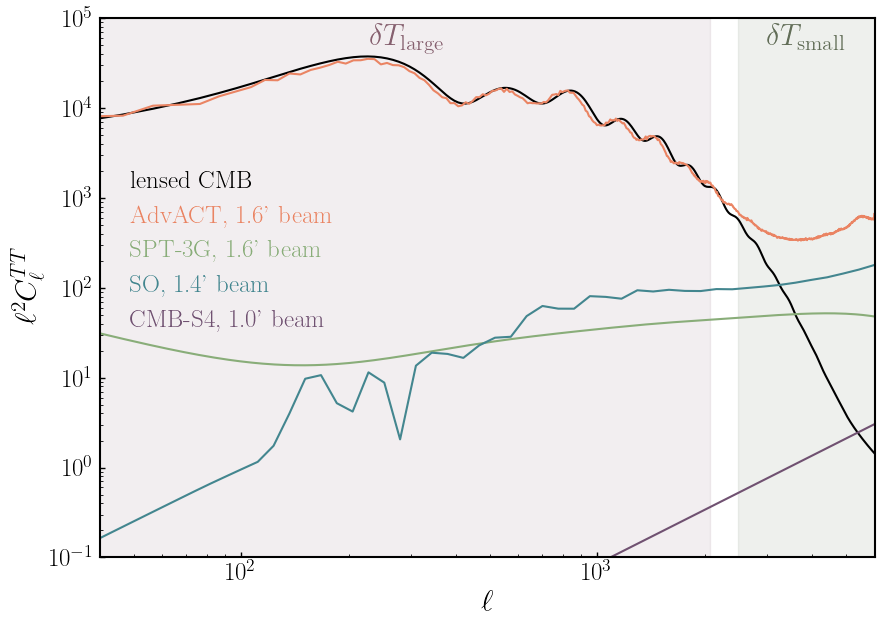

In [12]:
beam = 1.6
noise = 5.
cmb = make_cmb(lMax=6000, beam=beam, noise=noise)
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.plot(act_ell, act_ell**2*cmb.flensedTT(act_ell), label=r'lensed CMB', c='k')
ax.plot(act_ell, act_ell**2*act_cl, label=r"AdvACT, %.1f' beam"%beam, c=cols[3])

beam = 1.6
noise = 5.
cmb = make_cmb(lMax=6000, beam=beam, noise=noise)
ax.plot(spt_ell, spt_ell**2*(spt_cl * cmb.fbeam(spt_ell)**2), label=r"SPT-3G, %.1f' beam"%beam, c=cols[2])

beam = 1.4
noise = 5.
cmb = make_cmb(lMax=6000, beam=beam, noise=noise)
ax.plot(so_goal_ell_interp, so_goal_ell_interp**2*(so_goal_cl_interp(so_goal_ell_interp) * cmb.fbeam(so_goal_ell_interp)**2),
        label=r"SO, %.1f' beam"%beam, c=cols[1])

beam = 1.
noise = 1.
cmb = make_cmb(lMax=6000, beam=beam, noise=noise)
# ax.plot(spt_ell, spt_ell**2*((cmb.ftotal(spt_ell) - cmb.flensedTT(spt_ell)) * cmb.fbeam(spt_ell)**2),
#         label=r"CMB-S4, beam=%.1f'"%beam, c=cols[0])
ax.plot(spt_ell, spt_ell**2*(cmb.fdetectorNoise(spt_ell) * cmb.fbeam(spt_ell)**2),
        label=r"CMB-S4, %.1f' beam"%beam, c=cols[0])
ax.loglog()
l = ax.legend(loc=(0,0.4), frameon=False, framealpha=1., borderaxespad=0., fancybox=False, edgecolor='k', handlelength=0)
# l.get_frame().set_linewidth(1.5)
# l._legend_box.align='right'
ax.set_ylim(1e-1, 1e5)
ax.set_xlim(40, 6000)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell^2C_{\ell}^{TT}$')
ax.grid(False)
ax.fill_between(x=[0, 2075], y1=[1e5, 1e5], color='#86606f', alpha=0.1)
ax.fill_between(x=[2475, 1e5], y1=[1e5, 1e5], color='#626e58', alpha=0.1)
ax.text(230, 50000, r'$\delta T_{\rm large}$', {'color': '#86606f', 'fontsize': 22})
ax.text(3000, 50000, r'$\delta T_{\rm small}$', {'color': '#626e58', 'fontsize': 22})

# max_shift = max([t.get_window_extent().width for t in l.get_texts()])
for line, text in zip(l.get_lines(), l.get_texts()):
    text.set_color(line.get_color())
    # text.set_ha('right')
    # temp_shift = max_shift - text.get_window_extent().width
    # text.set_position((temp_shift, 0))

### Make figure with signal power spectrum

In [17]:
taumap, boxMask, wcs = make_basemap()
taumap.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/cmass_m_10x10_tau_final/cmass_m_10x10_tau_final_flatmap.fits')

reading from /home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/cmass_m_10x10_tau_final/cmass_m_10x10_tau_final_flatmap.fits


/home/theo/Documents/research/CMB/patchy_tau_sims/notebooks/../../ThumbStack/flat_map.py:459: RuntimeWarning: invalid value encountered in divide
  sCl /= np.sqrt(Nmodes)


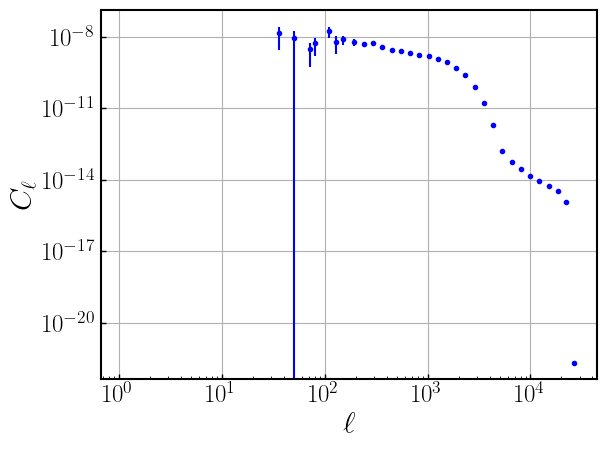

In [18]:
tau_ell, tau_cl, tau_scl = taumap.powerSpectrum(plot=True)

In [19]:
print(tau_ell)
print(tau_cl)

[1.11470873e+00 1.37044237e+00 1.68484577e+00 2.07137880e+00
 2.54658925e+00 3.13082128e+00 3.84908633e+00 4.73213392e+00
 5.81776804e+00 7.15246558e+00 8.79336603e+00 1.08107177e+01
 1.32908850e+01 1.63400461e+01 2.00887378e+01 2.46974450e+01
 3.03634699e+01 3.60000000e+01 4.58933913e+01 5.09116882e+01
 7.20000000e+01 8.04984472e+01 1.09223860e+02 1.29799846e+02
 1.51937301e+02 1.91270149e+02 2.41465841e+02 2.98367968e+02
 3.62562851e+02 4.48083110e+02 5.51018255e+02 6.74563738e+02
 8.30185858e+02 1.02254115e+03 1.25662127e+03 1.54353860e+03
 1.89580859e+03 2.33023163e+03 2.86609699e+03 3.52478806e+03
 4.33291862e+03 5.32556018e+03 6.54641300e+03 8.04916276e+03
 9.89677158e+03 1.21670163e+04 1.49576873e+04 1.83891357e+04
 2.21404303e+04 2.66978844e+04]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000

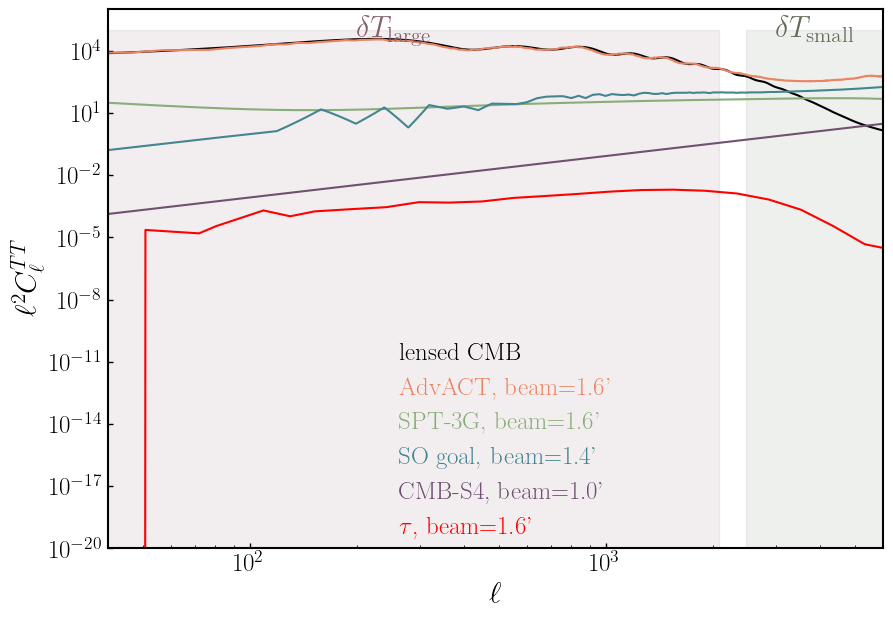

In [20]:
beam = 1.6
noise = 5.
cmb = make_cmb(lMax=20000, beam=beam, noise=noise)
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.plot(act_ell, act_ell**2*cmb.flensedTT(act_ell), label=r'lensed CMB', c='k')
ax.plot(act_ell, act_ell**2*act_cl, label=r"AdvACT, beam=%.1f'"%beam, c=cols[3])

beam = 1.6
noise = 5.
cmb = make_cmb(lMax=20000, beam=beam, noise=noise)
ax.plot(spt_ell, spt_ell**2*(spt_cl * cmb.fbeam(spt_ell)**2), label=r"SPT-3G, beam=%.1f'"%beam, c=cols[2])

beam = 1.4
noise = 5.
cmb = make_cmb(lMax=20000, beam=beam, noise=noise)
ax.plot(so_goal_ell, so_goal_ell**2*(so_goal_cl * cmb.fbeam(so_goal_ell)**2), label=r"SO goal, beam=%.1f'"%beam, c=cols[1])

beam = 1.
noise = 1.
cmb = make_cmb(lMax=6000, beam=beam, noise=noise)
# ax.plot(spt_ell, spt_ell**2*((cmb.ftotal(spt_ell) - cmb.flensedTT(spt_ell)) * cmb.fbeam(spt_ell)**2),
#         label=r"CMB-S4, beam=%.1f'"%beam, c=cols[0])
ax.plot(spt_ell, spt_ell**2*(cmb.fdetectorNoise(spt_ell) * cmb.fbeam(spt_ell)**2),
        label=r"CMB-S4, beam=%.1f'"%beam, c=cols[0])

ax.plot(tau_ell, tau_ell**2*(tau_cl),
        label=r"$\tau$, beam=1.6'", c='r')
ax.loglog()
l = ax.legend(loc='lower center', frameon=False, framealpha=1., borderaxespad=0., fancybox=False, edgecolor='k', handlelength=0)
# l.get_frame().set_linewidth(1.5)
# l._legend_box.align='right'
ax.set_ylim(1e-20, 1e6)
ax.set_xlim(40, 6000)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell^2C_{\ell}^{TT}$')
ax.grid(False)
ax.fill_between(x=[0, 2075], y1=[1e5, 1e5], color='#86606f', alpha=0.1)
ax.fill_between(x=[2475, 1e5], y1=[1e5, 1e5], color='#626e58', alpha=0.1)
ax.text(200, 50000, r'$\delta T_{\rm large}$', {'color': '#86606f', 'fontsize': 22})
ax.text(3000, 50000, r'$\delta T_{\rm small}$', {'color': '#626e58', 'fontsize': 22})

# max_shift = max([t.get_window_extent().width for t in l.get_texts()])
for line, text in zip(l.get_lines(), l.get_texts()):
    text.set_color(line.get_color())
    # text.set_ha('right')
    # temp_shift = max_shift - text.get_window_extent().width
    # text.set_position((temp_shift, 0))

/home/theo/Documents/research/CMB/patchy_tau_sims/notebooks/../../ThumbStack/cmb.py:31: RuntimeWarning: divide by zero encountered in divide
  self.fdl_to_cl = lambda l: 1./( l*(l+1.)/(2.*np.pi) )
/home/theo/Documents/research/CMB/patchy_tau_sims/notebooks/../../ThumbStack/cmb.py:79: RuntimeWarning: invalid value encountered in multiply
  self.flensedTT = lambda l: ((l>=lmin_lensedCMB) & (l<=lmax_lensedCMB)) * self.flensedTT_template(l) * self.fdl_to_cl(l)


182.82539111145707
Text(0, 0, "AdvACT, 1.6' beam") 145.42008301389322 37.40530809756385
Text(0, 0, "SPT-3G, 1.6' beam") 138.75493753891658 44.07045357254049
Text(0, 0, "SO, 1.4' beam") 101.76486612702367 81.0605249844334
Text(0, 0, "CMB-S4 (no fg), 1' beam") 182.82539111145707 0.0


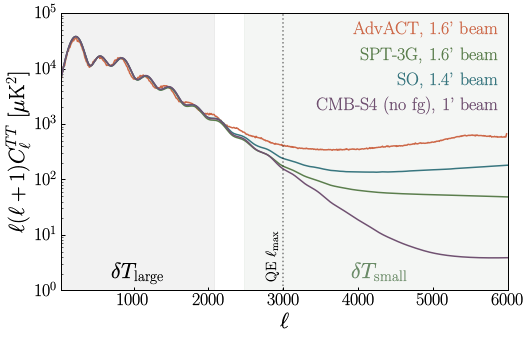

In [12]:
cols = ['#705171', '#38767F', '#5B7E4D', '#cd6848']
cols = cols[::-1]

beam = 1.6
noise = 5.
cmb = make_cmb(lMax=20000, beam=beam, noise=noise)
fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=72)
# ax.plot(act_ell, act_ell**2*cmb.flensedTT(act_ell), label=r'lensed CMB', c='k')
act = ax.plot(act_ell, (act_ell**2 + act_ell)*act_cl, label="AdvACT, %.1f' beam"%beam, c=cols[0])

beam = 1.6
noise = 5.
cmb = make_cmb(lMax=6000, beam=beam, noise=noise)
spt = ax.plot(spt_ell, (spt_ell**2 + spt_ell)*((cmb.flensedTT(spt_ell) +spt_cl) * cmb.fbeam(spt_ell)**2),
         label="SPT-3G, %.1f' beam"%beam, c=cols[1])

beam = 1.4
noise = 5.
cmb = make_cmb(lMax=6000, beam=beam, noise=noise)
so = ax.plot(so_goal_ell, (so_goal_ell**2 + so_goal_ell)*((cmb.flensedTT(so_goal_ell) + so_goal_cl) * cmb.fbeam(so_goal_ell)**2),
        label="SO, %.1f' beam"%beam, c=cols[2])

beam = 1.
noise = 1.
cmb = make_cmb(lMax=6000, beam=beam, noise=noise)
# ax.plot(spt_ell, spt_ell**2*((cmb.ftotal(spt_ell) - cmb.flensedTT(spt_ell)) * cmb.fbeam(spt_ell)**2),
#         label=r"CMB-S4, beam=%.1f'"%beam, c=cols[0])
s4 = ax.plot(spt_ell, (spt_ell**2 + spt_ell)*((cmb.flensedTT(spt_ell) + cmb.fdetectorNoise(spt_ell)) * cmb.fbeam(spt_ell)**2),
        label="CMB-S4 (no fg), %i' beam"%beam, c=cols[3])

# ax.plot(tau_ell, tau_ell**2*(tau_cl),
#         label=r"$\tau$, beam=1.6'", c='r')
# ax.loglog()
l = ax.legend(loc='upper right', frameon=False, borderaxespad=0.1, handlelength=0., handletextpad=0.,
              fancybox=False, framealpha=1., edgecolor='k')
for lh in l.legend_handles:
    lh.set_visible(False)
l.get_frame().set_linewidth(0)
ax.set_ylim(1e0, 1e5)
ax.set_xlim(30, 6000)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell(\ell +1)C_{\ell}^{TT}$ [$\mu$K$^2$]')
ax.set_yscale('log')
ax.grid(False)
# small_color = '#626e58'
# large_color = '#86606f'
# small_color = '#5ca5b6'
small_color = '#6a8b67'
large_color = 'k'
ax.fill_between(x=[0, 2075], y1=[1e5, 1e5], color=large_color, alpha=0.05)
# ax.fill_between(x=[0, 2075], y1=[1e5, 1e5], color='#86606f', alpha=0.1)
ax.fill_between(x=[2475, 1e5], y1=[1e5, 1e5], color=small_color, alpha=0.07)
ax.axvline(3000, ls=':', c='k', alpha=0.5)
ax.text(700, 1.6, r'$\delta T_{\rm large}$', {'color': large_color, 'fontsize': 22})
ax.text(3900, 1.6, r'$\delta T_{\rm small}$', {'color': small_color, 'fontsize': 22})
ax.text(2780, 1.6, r'QE $\ell_{\rm max}$', {'color': 'k', 'fontsize': 15, 'rotation': 'vertical'})

max_shift = max([t.get_window_extent().width for t in l.get_texts()])
print(max_shift)
l._legend_box.align='right'
for i, text in enumerate(l.get_texts()):
    text.set_color(cols[i])
    text.set_ha('right')
    temp_shift = max_shift - text.get_window_extent().width
    print(text, text.get_window_extent().width, temp_shift)
    text.set_position((temp_shift, 0))

fn = '/home/theo/Documents/research/CMB/patchy_tau_sims/paper_figures/noise_powspec/ti-sgn_noise_spec_linlog_v3'
plt.savefig(fn+'.pdf', dpi=72, bbox_inches='tight')
plt.savefig(fn+'.png', dpi=72, bbox_inches='tight')

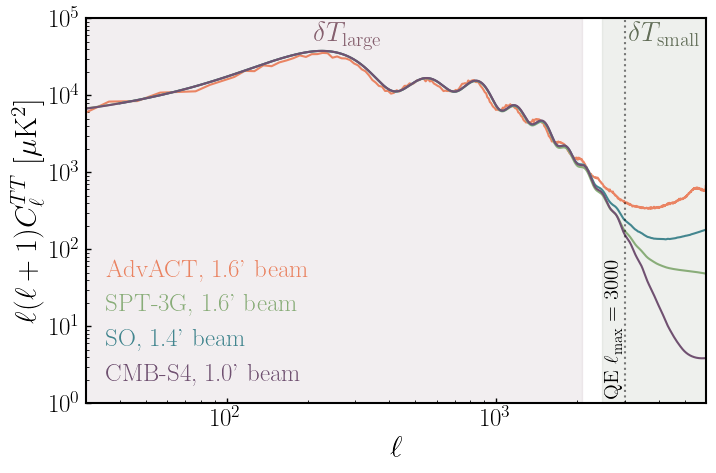

In [18]:
beam = 1.6
noise = 5.
cmb = make_cmb(lMax=20000, beam=beam, noise=noise)
fig, ax = plt.subplots(1,1, figsize=(8,5))
# ax.plot(act_ell, act_ell**2*cmb.flensedTT(act_ell), label=r'lensed CMB', c='k')
ax.plot(act_ell, (act_ell**2 + act_ell)*act_cl, label="AdvACT, %.1f' beam"%beam, c=cols[0])

beam = 1.6
noise = 5.
cmb = make_cmb(lMax=6000, beam=beam, noise=noise)
ax.plot(spt_ell, (spt_ell**2 + spt_ell)*((cmb.flensedTT(spt_ell) +spt_cl) * cmb.fbeam(spt_ell)**2), label="SPT-3G, %.1f' beam"%beam, c=cols[1])

beam = 1.4
noise = 5.
cmb = make_cmb(lMax=6000, beam=beam, noise=noise)
ax.plot(so_goal_ell, (so_goal_ell**2 + so_goal_ell)*((cmb.flensedTT(so_goal_ell) + so_goal_cl) * cmb.fbeam(so_goal_ell)**2),
        label="SO, %.1f' beam"%beam, c=cols[2])

beam = 1.
noise = 1.
cmb = make_cmb(lMax=6000, beam=beam, noise=noise)
# ax.plot(spt_ell, spt_ell**2*((cmb.ftotal(spt_ell) - cmb.flensedTT(spt_ell)) * cmb.fbeam(spt_ell)**2),
#         label=r"CMB-S4, beam=%.1f'"%beam, c=cols[0])
ax.plot(spt_ell, (spt_ell**2 + spt_ell)*((cmb.flensedTT(spt_ell) + cmb.fdetectorNoise(spt_ell)) * cmb.fbeam(spt_ell)**2),
        label="CMB-S4, %.1f' beam"%beam, c=cols[3])

# ax.plot(tau_ell, tau_ell**2*(tau_cl),
#         label=r"$\tau$, beam=1.6'", c='r')
ax.loglog()
l = ax.legend(loc='lower left', frameon=False, borderaxespad=0.3, handlelength=0, handletextpad=0.1, fancybox=False)
for lh in l.legend_handles:
    lh.set_visible(False)
# l.get_frame().set_linewidth(1.5)
# l._legend_box.align='right'
ax.set_ylim(1e0, 1e5)
ax.set_xlim(30, 6000)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$\ell(\ell +1)C_{\ell}^{TT}$ [$\mu$K$^2$]')
ax.grid(False)
ax.fill_between(x=[0, 2075], y1=[1e5, 1e5], color='#86606f', alpha=0.1)
# ax.fill_between(x=[0, 2075], y1=[1e5, 1e5], color='#86606f', alpha=0.1)
ax.fill_between(x=[2475, 1e5], y1=[1e5, 1e5], color='#626e58', alpha=0.1)
ax.axvline(3000, ls=':', c='k', alpha=0.5)
ax.text(210, 50000, r'$\delta T_{\rm large}$', {'color': '#86606f', 'fontsize': 20})
ax.text(3100, 50000, r'$\delta T_{\rm small}$', {'color': '#626e58', 'fontsize': 20})
ax.text(2520, 1.3, r'QE $\ell_{\rm max}=3000$', {'color': 'k', 'fontsize': 15, 'rotation': 'vertical'})

# max_shift = max([t.get_window_extent().width for t in l.get_texts()])
for i, text in enumerate(l.get_texts()):
    text.set_color(cols[i])

fn = '/home/theo/Documents/research/CMB/patchy_tau_sims/paper_figures/noise_powspec/ti-sgn_noise_spec_loglog'
plt.savefig(fn+'.pdf', dpi=300, bbox_inches='tight')
plt.savefig(fn+'.png', dpi=100, bbox_inches='tight')

In [306]:
print(act_ell)

[   6.5   16.5   26.5   36.5   46.5   56.5   66.5   76.5   86.5   96.5
  106.5  116.5  126.5  136.5  146.5  156.5  166.5  176.5  186.5  196.5
  206.5  216.5  226.5  236.5  246.5  256.5  266.5  276.5  286.5  296.5
  306.5  316.5  326.5  336.5  346.5  356.5  366.5  376.5  386.5  396.5
  406.5  416.5  426.5  436.5  446.5  456.5  466.5  476.5  486.5  496.5
  506.5  516.5  526.5  536.5  546.5  556.5  566.5  576.5  586.5  596.5
  606.5  616.5  626.5  636.5  646.5  656.5  666.5  676.5  686.5  696.5
  706.5  716.5  726.5  736.5  746.5  756.5  766.5  776.5  786.5  796.5
  806.5  816.5  826.5  836.5  846.5  856.5  866.5  876.5  886.5  896.5
  906.5  916.5  926.5  936.5  946.5  956.5  966.5  976.5  986.5  996.5
 1006.5 1016.5 1026.5 1036.5 1046.5 1056.5 1066.5 1076.5 1086.5 1096.5
 1106.5 1116.5 1126.5 1136.5 1146.5 1156.5 1166.5 1176.5 1186.5 1196.5
 1206.5 1216.5 1226.5 1236.5 1246.5 1256.5 1266.5 1276.5 1286.5 1296.5
 1306.5 1316.5 1326.5 1336.5 1346.5 1356.5 1366.5 1376.5 1386.5 1396.5
 1406.

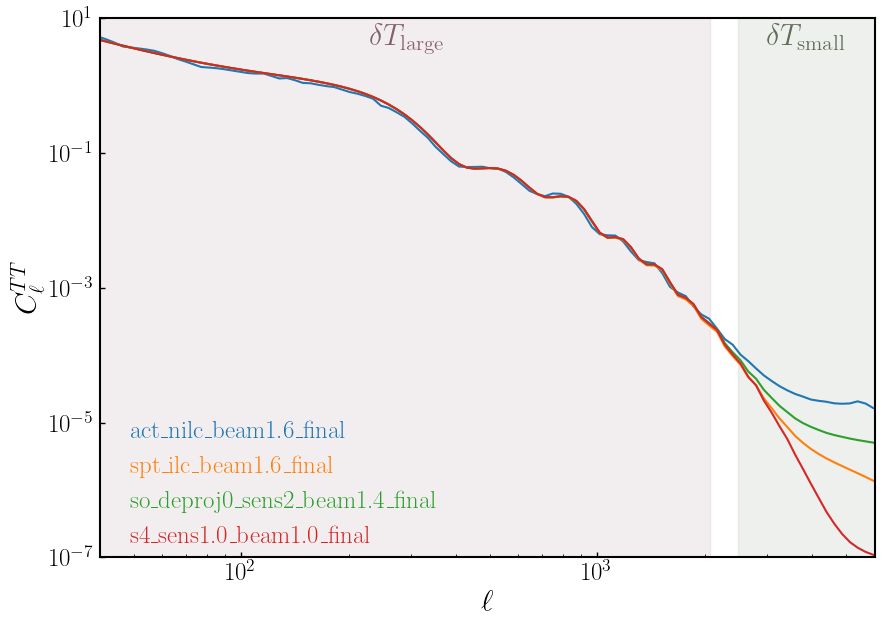

In [316]:
basemap = make_basemap()

datadir = '/home/theo/Documents/research/CMB/patchy_tau_sims/data/AdvACT_NILC_cls_fullRes_TT/'
act_ell = np.load(datadir+'ells.npy')
act_cl = np.load(datadir+'cl_tt.npy')
act_fn = interp1d(act_ell, act_cl, kind='linear', bounds_error=False, fill_value=0.)

datadir = '/home/theo/Documents/research/CMB/patchy_tau_sims/data/noisecurve_subset/'
data = np.load(datadir + 'spt_proposal_2023_ilc_cmb_90-150-220_TT-EE_fsky1500_5years.npy', allow_pickle=True).tolist()
spt_ell = data['el']
spt_cl = data['cl_residual']['TT']
spt_fn = interp1d(spt_ell, spt_cl, kind='linear', bounds_error=False, fill_value=0.)

so_dat = np.genfromtxt(datadir + 'SOV3_T_default1-4-2_noisecurves_deproj0_SENS2_mask_16000_ell_TT_yy.txt')
so_ell = so_dat[:,0]
so_cl = so_dat[:,1]
so_fn = interp1d(so_ell, so_cl, kind='linear', bounds_error=False, fill_value=0.)

ell_all = np.logspace(np.log10(40.), np.log10(5950.), 100) #act ell max = 5986.5

fig, ax = plt.subplots(1,1, figsize=(10,7))

# AdvACT
label = 'act_nilc_beam1.6_final'
actmap = ax.plot(ell_all, act_fn(ell_all), label=label)

# SPT-3G
cmb = make_cmb(lMax=6000, beam=1.6, noise=1.)
label = 'spt_ilc_beam1.6_final'
actmap = ax.plot(ell_all, (cmb.flensedTT(ell_all) + spt_fn(ell_all)) * cmb.fbeam(ell_all)**2, label=label)

# SPT-3G
cmb = make_cmb(lMax=6000, beam=1.4, noise=9.5)
label = 'so_deproj0_sens2_beam1.4_final'
actmap = ax.plot(ell_all, (cmb.flensedTT(ell_all) + so_fn(ell_all)) * cmb.fbeam(ell_all)**2, label=label)

# CMB-S4
cmb = make_cmb(lMax=6000, beam=1., noise=1.)
label = 's4_sens1.0_beam1.0_final'
actmap = ax.plot(ell_all, (cmb.flensedTT(ell_all) + cmb.fdetectorNoise(ell_all)) * cmb.fbeam(ell_all)**2, label=label)

ax.loglog()
l = ax.legend(loc='lower left', frameon=False, framealpha=1., borderaxespad=0., fancybox=False, edgecolor='k', handlelength=0)
# l.get_frame().set_linewidth(1.5)
# l._legend_box.align='right'
ax.set_ylim(1e-7, 1e1)
ax.set_xlim(40, 6000)
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$C_{\ell}^{TT}$')
ax.grid(False)
ax.fill_between(x=[0, 2075], y1=[1e5, 1e5], color='#86606f', alpha=0.1)
ax.fill_between(x=[2475, 1e5], y1=[1e5, 1e5], color='#626e58', alpha=0.1)
ax.text(230, 4, r'$\delta T_{\rm large}$', {'color': '#86606f', 'fontsize': 22})
ax.text(3000, 4, r'$\delta T_{\rm small}$', {'color': '#626e58', 'fontsize': 22})

# max_shift = max([t.get_window_extent().width for t in l.get_texts()])
for line, text in zip(l.get_lines(), l.get_texts()):
    text.set_color(line.get_color())

# Let's make some maaappsss

In [317]:
from make_noise_maps import make_cmb, gen_map_from_data_powspec, save_map

basemap, boxMask, wcs = make_basemap()

datadir = '/home/theo/Documents/research/CMB/patchy_tau_sims/data/AdvACT_NILC_cls_fullRes_TT/'
act_ell = np.load(datadir+'ells.npy')
act_cl = np.load(datadir+'cl_tt.npy')
act_fn = interp1d(act_ell, act_cl, kind='linear', bounds_error=False, fill_value=0.)

datadir = '/home/theo/Documents/research/CMB/patchy_tau_sims/data/noisecurve_subset/'
data = np.load(datadir + 'spt_proposal_2023_ilc_cmb_90-150-220_TT-EE_fsky1500_5years.npy', allow_pickle=True).tolist()
spt_ell = data['el']
spt_cl = data['cl_residual']['TT']
spt_fn = interp1d(spt_ell, spt_cl, kind='linear', bounds_error=False, fill_value=0.)

so_dat = np.genfromtxt(datadir + 'SOV3_T_default1-4-2_noisecurves_deproj0_SENS2_mask_16000_ell_TT_yy.txt')
so_ell = so_dat[:,0]
so_cl = so_dat[:,1]
so_fn = interp1d(so_ell, so_cl, kind='linear', bounds_error=False, fill_value=0.)

ell_all = np.logspace(np.log10(40), np.log10(5950.), 100) #act ell max = 5986.5


cmb = make_cmb(lMax=6000, beam=1.6, noise=15.)
outdir = '/home/theo/Documents/research/CMB/patchy_tau_sims/output/cmb_maps/10x10_noise_maps/'

# AdvACT
name = 'act_nilc_beam1.6_final'
actmap = gen_map_from_data_powspec(ell_all, act_fn(ell_all), cmb, basemap, name=name)
save_map(actmap, cmb, outdir, name)

# SPT-3G
cmb = make_cmb(lMax=6000, beam=1.6, noise=1.)
name = 'spt_ilc_beam1.6_final'
actmap = gen_map_from_data_powspec(ell_all, (cmb.flensedTT(ell_all) + spt_fn(ell_all)) * cmb.fbeam(ell_all)**2, cmb, basemap, name=name)
save_map(actmap, cmb, outdir, name)

# SO
cmb = make_cmb(lMax=6000, beam=1.4, noise=9.5)
name = 'so_deproj0_sens2_beam1.4_final'
actmap = gen_map_from_data_powspec(ell_all, (cmb.flensedTT(ell_all) + so_fn(ell_all)) * cmb.fbeam(ell_all)**2, cmb, basemap, name=name)
save_map(actmap, cmb, outdir, name)

# CMB-S4
cmb = make_cmb(lMax=6000, beam=1., noise=1.)
name = 's4_sens1.0_beam1.0_final'
actmap = gen_map_from_data_powspec(ell_all, (cmb.flensedTT(ell_all) + cmb.fdetectorNoise(ell_all)) * cmb.fbeam(ell_all)**2, cmb, basemap, name=name)
save_map(actmap, cmb, outdir, name)

Generating map
plot and save CMB map png
saving plot to /home/theo/Documents/research/CMB/patchy_tau_sims/output/cmb_maps/10x10_noise_maps/act_nilc_beam1.6_final/act_nilc_beam1.6_final_map.png
plot and save the power spectrum


/home/theo/Documents/research/CMB/patchy_tau_sims/notebooks/../../ThumbStack/flat_map.py:459: RuntimeWarning: invalid value encountered in divide
  sCl /= np.sqrt(Nmodes)


Saving plot to: /home/theo/Documents/research/CMB/patchy_tau_sims/output/cmb_maps/10x10_noise_maps/act_nilc_beam1.6_final/act_nilc_beam1.6_final_powspec.png
Saving flatmap: /home/theo/Documents/research/CMB/patchy_tau_sims/output/cmb_maps/10x10_noise_maps/act_nilc_beam1.6_final/act_nilc_beam1.6_final_flatmap.fits
writing to /home/theo/Documents/research/CMB/patchy_tau_sims/output/cmb_maps/10x10_noise_maps/act_nilc_beam1.6_final/act_nilc_beam1.6_final_flatmap.fits
Generating map
plot and save CMB map png
saving plot to /home/theo/Documents/research/CMB/patchy_tau_sims/output/cmb_maps/10x10_noise_maps/spt_ilc_beam1.6_final/spt_ilc_beam1.6_final_map.png
plot and save the power spectrum
Saving plot to: /home/theo/Documents/research/CMB/patchy_tau_sims/output/cmb_maps/10x10_noise_maps/spt_ilc_beam1.6_final/spt_ilc_beam1.6_final_powspec.png
Saving flatmap: /home/theo/Documents/research/CMB/patchy_tau_sims/output/cmb_maps/10x10_noise_maps/spt_ilc_beam1.6_final/spt_ilc_beam1.6_final_flatmap.fi

<Figure size 640x480 with 0 Axes>